In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

/usr/local/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


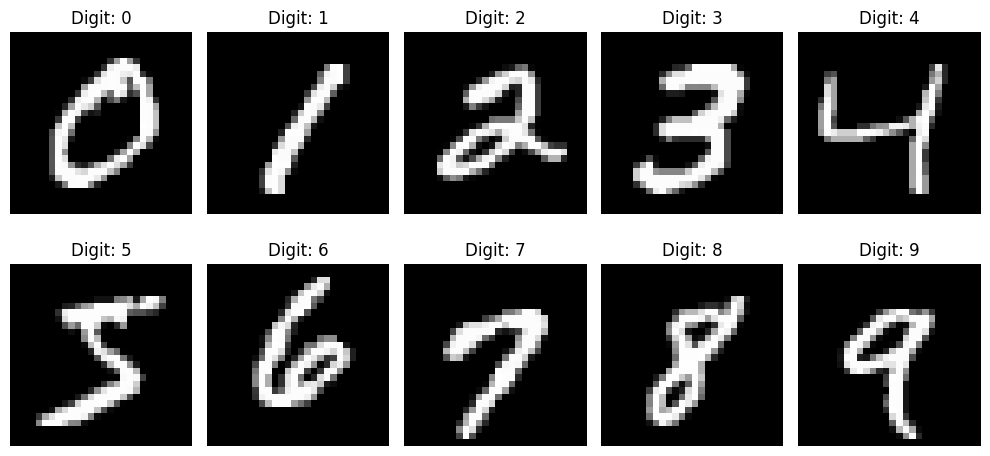

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
Xraw, Yraw = mnist.data, mnist.target

# Convert Yraw to integers
Yraw = Yraw.astype(int)

# Plot one example of each digit
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(Xraw[Yraw == i].iloc[0].values.reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
print(Xraw.shape, Yraw.shape)
Xraw = Xraw.to_numpy()
Yraw = Yraw.to_numpy()

(70000, 784) (70000,)


In [4]:
d = 100
M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X = M @ Xraw.T

Y = np.zeros((10, Yraw.size))
Y[Yraw, np.arange(Yraw.size)] = 1

print(X.shape, Y.shape)
print(X[0], len(X[0]))
print(Y[0], len(Y[0]))
np.sum(Y[0]), np.sum(Y[:, 0])

(100, 70000) (10, 70000)
[0.53462265 0.5616759  0.36010222 ... 0.52485208 0.48669514 0.80162627] 70000
[0. 1. 0. ... 0. 0. 0.] 70000


(6903.0, 1.0)

In [5]:
W = Y @ np.linalg.pinv(X)
print(W.shape, "\n", W)

(10, 100) 
 [[-2.85964920e-01  3.15083200e-02 -7.35541920e-01 -1.13194997e+00
   9.83814292e-01 -1.30422022e+00 -2.16369153e-01 -3.33887574e-01
  -3.39131487e-01  1.43628570e-01  6.23395294e-02 -5.82944760e-01
  -3.71293686e-01 -1.86718400e+00 -6.71991589e-01  1.50038873e+00
  -6.99420105e-03 -9.45404628e-01 -1.73453324e-01  1.91748007e+00
  -6.87419477e-01 -1.89360763e+00  1.52899902e-01  3.77912063e-01
  -1.91635511e+00 -4.91205337e-02  5.66922702e-01  8.82202879e-01
   7.76163930e-01  7.87408086e-01 -4.61040018e-01  1.74133440e+00
  -1.83567372e+00 -1.75872924e+00 -1.23264984e+00  4.06517168e-01
   1.82776193e+00  9.07255086e-01  5.41701780e-01  1.21387967e+00
   1.28912874e-01  1.05062290e+00 -1.79586320e+00 -9.63437342e-01
  -9.89647469e-01 -4.41528786e-01 -3.73150978e-01 -4.38821967e-01
  -9.37998853e-01  1.92201044e+00  6.73249101e-01  1.40419993e+00
   5.73597514e-01  1.21844569e+00  1.18249211e+00  4.41931577e-01
   4.46207393e-01 -3.94855953e-01  1.87906450e-01 -2.00510952e+0

In [6]:
d_values = [10, 50, 100, 200, 500]
mse_list = list()
mistakes_list = list()
random_mistakes_list = list()

for d in d_values:
    random_mistakes = 0
    for col in range(Y.shape[1]):
        random_number = np.random.randint(0, 10)
        if random_number != np.argmax(Y[:, col]):
            random_mistakes += 1
    random_mistakes_list.append(random_mistakes)

for d in d_values:
    M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
    X_temp = M @ Xraw.T
    
    W = Y @ np.linalg.pinv(X_temp)
    
    Y_pred = W @ X_temp

    mse = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_list.append(mse)

    mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))
    mistakes_list.append(mistakes)

results = pd.DataFrame({'d': d_values, 'MSE': mse_list, 'Mistakes': mistakes_list, "Random Mistakes": random_mistakes_list})
results.set_index('d', inplace=True)
print(results)

          MSE  Mistakes  Random Mistakes
d                                       
10   0.748613     35356            62908
50   0.527428     15820            62984
100  0.474622     12739            62936
200  0.421836     10936            63057
500  0.394128     10425            62972


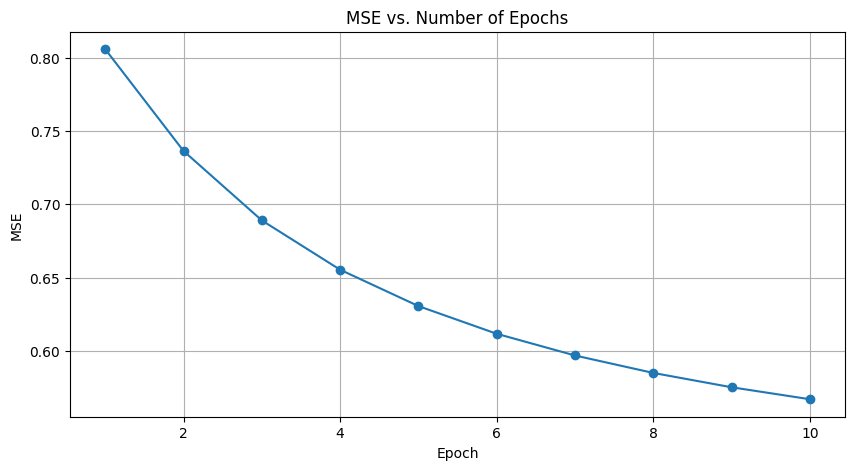

Number of mistakes with LMS algorithm (d=100): 16658
Number of mistakes with exact solution (d=100): 12739


In [7]:
d = 100
eta = 0.001
epochs = 10
mse_lms_list = list()

Y_labels = np.argmax(Y, axis=0)

M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X_train = M @ Xraw.T

W_lms = np.zeros((len(Y), len(X_train)))

for epoch in range(epochs):
    for i in range(X_train.shape[1]):
        grad = (Y[:, i] - W_lms @ X_train[:, i]).reshape((-1, 1)) @ X_train[:, i].reshape((1, -1))
        W_lms += eta * grad
    
    Y_pred = W_lms @ X_train
    mse_epoch = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_lms_list.append(mse_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_lms_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Epochs')
plt.grid(True)
plt.show()

Y_pred = W_lms @ X_train
mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))

print(f"Number of mistakes with LMS algorithm (d=100): {mistakes}")
print(f"Number of mistakes with exact solution (d=100): {mistakes_list[d_values.index(100)]}")

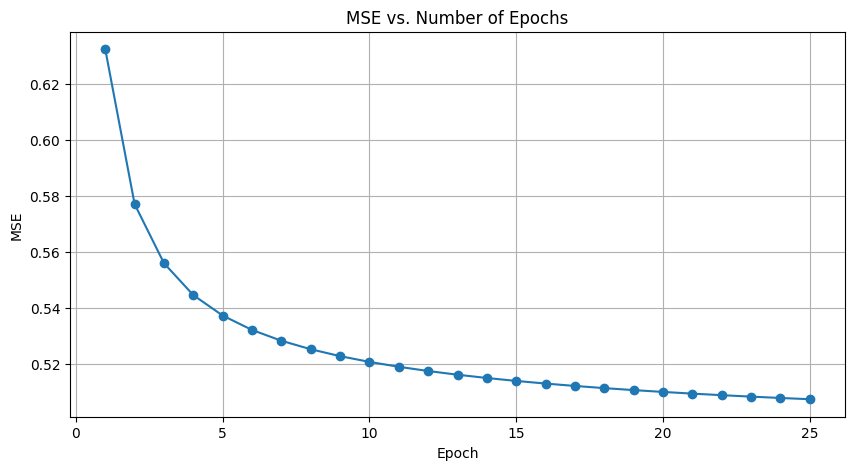

Number of mistakes with LMS algorithm (d=100): 13126
Number of mistakes with exact solution (d=100): 12739


In [8]:
d = 100
eta = 0.01
epochs = 25
mse_lms_list = list()

Y_labels = np.argmax(Y, axis=0)

M = np.random.uniform(0, 1, (d, 784)) / (255 * d)
X_train = M @ Xraw.T

W_lms = np.zeros((len(Y), len(X_train)))

for epoch in range(epochs):
    for i in range(X_train.shape[1]):
        grad = (Y[:, i] - W_lms @ X_train[:, i]).reshape((-1, 1)) @ X_train[:, i].reshape((1, -1))
        W_lms += eta * grad
    
    Y_pred = W_lms @ X_train
    mse_epoch = np.mean(np.linalg.norm(Y - Y_pred, axis=0) ** 2)
    mse_lms_list.append(mse_epoch)

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), mse_lms_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Epochs')
plt.grid(True)
plt.show()

Y_pred = W_lms @ X_train
mistakes = np.sum(np.argmax(Y, axis=0) != np.argmax(Y_pred, axis=0))

print(f"Number of mistakes with LMS algorithm (d=100): {mistakes}")
print(f"Number of mistakes with exact solution (d=100): {mistakes_list[d_values.index(100)]}")